## Generating Synthetic Seismogram for Marmousi Model in Python
#### Six steps to generate seismogram from density and velocity model files
#### Yonghai Zhang
###  yonghai.zhang@web.de

In this project, synthetic seismogram will be generated using velocity and density sections, the output will be a simulated seismic section.

Some steps are required to generate seismic section:<br>
1- Density an velocity model loading<br>
2- Depth domain reflection coefficients<br>
3- Resample Rc in time domain<br>
4- Convolution with Ricker wavelet<br>
5- Plot seismic section<br>
6- Out seismic section in Segy format<br>

The project is based on the online prject:<br>
https://towardsdatascience.com/generating-synthetic-seismogram-in-python-519f23f07894

by Ryan A. Mardani

## 1- Data Prepration

We will input data in SEGY format from density and velocity model files. 

In [1]:
import segyio
import numpy as np
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
den=segyio.open('MODEL_DENSITY_125cm.segy', ignore_geometry=True)
vel=segyio.open('MODEL_P-WAVE_VELOCITY_125cm.segy', ignore_geometry=True)

n_il = 1
n_xl = den.bin[segyio.BinField.Traces]
n_sam = den.bin[segyio.BinField.Samples]
del_D = den.bin[segyio.BinField.Interval] 
den.bin

{JobID: 0, LineNumber: 0, ReelNumber: 0, Traces: 13601, AuxTraces: 0, Interval: 1250, IntervalOriginal: 1250, Samples: 2801, SamplesOriginal: 2801, Format: 1, EnsembleFold: 0, SortingCode: 0, VerticalSum: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 3, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 0, MeasurementSystem: 1, ImpulseSignalPolarity: 0, VibratoryPolarity: 0, ExtAuxTraces: 0, ExtSamples: 0, ExtSamplesOriginal: 0, ExtEnsembleFold: 0, SEGYRevision: 0, SEGYRevisionMinor: 0, TraceFlag: 0, ExtendedHeaders: 0}

## 2- Reflection Coefficient in Depth Domain 

In [3]:
den_tr=den.trace.raw[:]
vel_tr=vel.trace.raw[:]
#acoustic impedence
Imp=den_tr*vel_tr
#reflection coefficient
Rc = np.zeros_like(Imp)
for i in range(n_xl):
    for j in range(n_sam-1):
        Rc[i][j]=(Imp[i][j+1]-Imp[i][j])/(Imp[i][j+1]+Imp[i][j])

## 3- Reflection Coefficient in Time Domain

In [4]:
dt_iterval = np.zeros_like(vel_tr)
TWT = np.zeros_like(vel_tr)
dt_iterval = 2*del_D/1000./vel_tr
TWT = np.cumsum(dt_iterval,axis=1)

dt = 0.004   #sampleing interval
t_max = 4.004   # max time to create time vector
t = np.repeat(np.arange(0, t_max, dt)[None, :], n_xl, axis=0)
#t = np.arange(0, t_max, dt)
Imp_tdom = np.array([np.interp(x=t[i], xp=TWT[i], fp=Imp[i]) for i in range(n_xl)])
#Imp_tdom = np.interp(x=t, xp = TWT, fp = Imp)    #resampling

In [5]:
Rc_tdom = np.zeros_like(Imp_tdom)
for i in range(n_xl):
    for j in range(np.int(t_max/dt)):
        Rc_tdom[i][j]=(Imp_tdom[i][j+1]-Imp_tdom[i][j])/(Imp_tdom[i][j+1]+Imp_tdom[i][j])

## 4-Wavelet & Convolution

#### Ricker wavelet

In [6]:
# define function of ricker wavelet
def ricker(f, length, dt):
    #t0 = np.arange(-length/2, (length-dt)/2, dt) ##should be corrected
    t0 = np.arange(-length/2, (length)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t0**2)) * np.exp(-(np.pi**2)*(f**2)*(t0**2))
    return t0, y

#### Convolution

In [7]:
f=20            #wavelet frequency
length=0.512    #Wavelet vector length
dt=dt           # Sampling prefer to use smiliar to resampled AI
t0, w = ricker (f, length, dt) # ricker wavelet 
synthetic = np.zeros_like(Rc_tdom)
for i in range(n_xl):
    synthetic[i] = np.convolve(w, Rc_tdom[i], mode='same')

## 5-Plot seismic section

In [8]:
import matplotlib.pyplot as plt

In [9]:
clip_percentile = 98
vm = np.percentile(synthetic, clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {synthetic.max():.0f}'

'The 98th percentile is 0; the max amplitude is 1'

Text(0.5, 1.0, 'Synthetic Seismic Section')

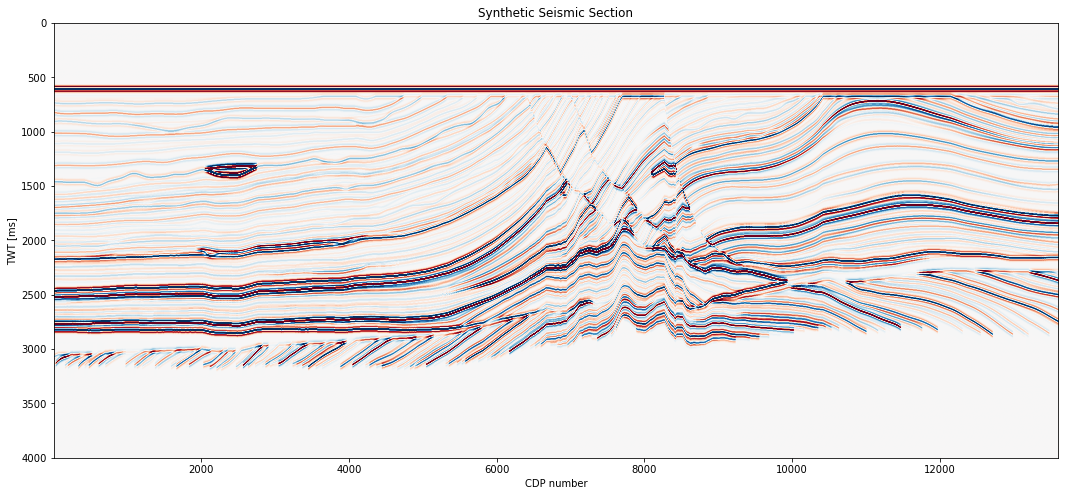

In [10]:
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
extent = [1, n_xl, t[0][-1]*1000, t[0][0]*1000]  # define extent
ax.imshow(synthetic.T, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto', extent=extent)
ax.set_xlabel('CDP number')
ax.set_ylabel('TWT [ms]')
ax.set_title(f'Synthetic Seismic Section')

## 6-Output seismic section to Segy file

In [11]:
seis='MODEL_SYNTHETIC_SEISMIC_4ms_125cm.segy'
#text header (EBCDIC header)
hf=open('seismic_4ms_125cm.txt','r')
ebcdic=hf.read()

spec = segyio.tools.metadata(den)

spec.samples = np.arange(0, t_max, dt)
spec.interval = 4000

with segyio.create(seis,spec) as dst:
    dst.text[0] = ebcdic

    dst.bin[3213] = n_xl
    dst.bin[3215] = 0
    dst.bin[3217] = 4000
    dst.bin[3219] = 4000
    dst.bin[3221] = 1001
    dst.bin[3223] = 1001
    
    for i in range(n_xl):
        dst.header[i] = den.header[i]
        dst.header[i][115] = 1001
        dst.header[i][117] = 4000
        dst.trace[i] = synthetic[i]